In [1]:
from protein_ligand import PDBProtein, parse_sdf_file
from reconstruct import reconstruct_from_generated
from rdkit import Chem, DataStructs
import numpy as np
import scipy.linalg
from rdkit.Chem import SDWriter, Descriptors, Draw, QED, rdFingerprintGenerator
from PIL import Image, ImageDraw, ImageFont
import networkx as nx
import rdkit
import sascorer
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import shutil
from tqdm import tqdm

In [2]:
data_props = pickle.load(open("data_props.p", "rb"))
data_path = '../../data/crossdocked/crossdocked_pocket10/crossdocked_pocket10/'
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=7)

In [3]:
def planarize_measure(lig_path):
    
    newmol = next(iter(Chem.SDMolSupplier(lig_path)))
    rdkit.Chem.rdDepictor.GenerateDepictionMatching3DStructure(newmol, newmol)
    
    with SDWriter('./outputs/tmp.sdf') as w:
        w.write(newmol)
    
    plane_lig_dict = parse_sdf_file('./outputs/tmp.sdf')
    
    finmol = reconstruct_from_generated(plane_lig_dict['pos'], plane_lig_dict['element'])
    return newmol,finmol

In [4]:
def generate_image(rdmol, filname):
    
    rdkit.Chem.rdDepictor.GenerateDepictionMatching3DStructure(rdmol, rdmol)
    pilimage = Draw.MolToImage(rdmol)

    # print(MolToSmiles(rdmol))

    # rdmol = AddHs(rdmol)
    # logp and qed are the same irrespective of hydrogen addition

    logp = (Descriptors.MolLogP(rdmol))
    qed = QED.qed(rdmol)
    # props = QED.properties(rdmol)
    sascore = sascorer.calculateScore(rdmol)

    res = Image.new(pilimage.mode, (300, 350), (255,255,255))
    res.paste(pilimage, (0, 50))

    I1 = ImageDraw.Draw(res)

    params = ("logp = %.2f QED = %.2f SA = %.2f" % (logp, qed, sascore))
    font = ImageFont.truetype("myfont.ttf", 15)
    # print(params)
    # Add Text to an image
    I1.text((40, 25), params, fill=(0, 0, 0), font=font)

    # Display edited image
    res.save('./outputs/'+filname+'.png')
    return res, qed, sascore, logp

In [9]:
f = 0
planar_orig_qeds = []
planar_plan_qeds = []
planar_orig_sascores = []
planar_plan_sascores = []
planar_orig_logps = []
planar_plan_logps = []
planar_ns = []
for i in tqdm(range(1000)):
    try:
        orig, plan = planarize_measure('./outputs/mxQED_planar/'+str(i)+'.sdf')
        planar_ns.append(plan.GetNumAtoms())
        orig_img, orig_qed, orig_sascore, orig_logp = generate_image(orig, 'tmp')
        plan_img, plan_qed, plan_sascore, plan_logp = generate_image(plan, 'tmp1')
        planar_orig_qeds.append(orig_qed)
        planar_plan_qeds.append(plan_qed)
        planar_orig_sascores.append(orig_sascore)
        planar_plan_sascores.append(plan_sascore)
        planar_orig_logps.append(orig_logp)
        planar_plan_logps.append(plan_logp)
        res = Image.new("RGB", (600, 350), (255,255,255))
        res.paste(orig_img, (0,0))
        res.paste(plan_img, (300,0))
        res.save('./outputs/planar_planar/'+str(i)+'.png')
        with SDWriter('./outputs/planar_planar/'+str(i)+'.sdf') as w:
            if(plan_qed >= orig_qed): w.write(plan)
            else: w.write(orig)
    except:
        f += 1
        planar_ns.append(0)
        planar_orig_qeds.append(-1)
        planar_plan_qeds.append(-1)
        planar_orig_sascores.append(-1)
        planar_plan_sascores.append(-1)
        planar_orig_logps.append(-10)
        planar_plan_logps.append(-10)
print(f, 'failed')

planar_orig_qeds = np.array(planar_orig_qeds)
planar_plan_qeds = np.array(planar_plan_qeds)
planar_ns = np.array(planar_ns)
planar_orig_sascores = np.array(planar_orig_sascores)
planar_plan_sascores = np.array(planar_plan_sascores)
planar_orig_logps = np.array(planar_orig_logps)
planar_plan_logps = np.array(planar_plan_logps)

 28%|█████████████████████▉                                                         | 278/1000 [00:18<00:45, 15.86it/s][23:14:56] atom 2 has specified valence (1) smaller than the drawn valence 2.
[23:14:56] atom 8 has specified valence (1) smaller than the drawn valence 2.
 50%|███████████████████████████████████████▌                                       | 501/1000 [00:33<00:31, 15.89it/s][23:15:11] atom 0 has specified valence (3) smaller than the drawn valence 4.
[23:15:11] atom 3 has specified valence (3) smaller than the drawn valence 4.
 65%|███████████████████████████████████████████████████                            | 646/1000 [00:42<00:24, 14.65it/s][23:15:20] atom 6 has specified valence (3) smaller than the drawn valence 4.
[23:15:20] atom 8 has specified valence (1) smaller than the drawn valence 2.
 66%|████████████████████████████████████████████████████▎                          | 662/1000 [00:43<00:20, 16.41it/s][23:15:21] atom 0 has specified valence (3) smaller than

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:05<00:00, 15.20it/s]

11 failed


In [6]:
np.sum(planar_ns>=10)

384

In [7]:
planar_max_qeds = np.maximum(planar_orig_qeds, planar_plan_qeds)
np.sum(np.delete(planar_plan_qeds-planar_orig_qeds, np.where(planar_ns<10))>0)

160

In [8]:
f = 0
all_orig_qeds = []
all_plan_qeds = []
all_orig_sascores = []
all_plan_sascores = []
all_orig_logps = []
all_plan_logps = []
all_ns = []
for i in tqdm(range(1000)):
    try:
        orig, plan = planarize_measure('./outputs/mxQED/'+str(i)+'.sdf')
        all_ns.append(plan.GetNumAtoms())
        orig_img, orig_qed, orig_sascore, orig_logp = generate_image(orig, 'tmp')
        plan_img, plan_qed, plan_sascore, plan_logp = generate_image(plan, 'tmp1')
        all_orig_qeds.append(orig_qed)
        all_plan_qeds.append(plan_qed)
        all_orig_sascores.append(orig_sascore)
        all_plan_sascores.append(plan_sascore)
        all_orig_logps.append(orig_logp)
        all_plan_logps.append(plan_logp)
        res = Image.new("RGB", (600, 350), (255,255,255))
        res.paste(orig_img, (0,0))
        res.paste(plan_img, (300,0))
        res.save('./outputs/planar/'+str(i)+'.png')
        with SDWriter('./outputs/planar/'+str(i)+'.sdf') as w:
            if(plan_qed >= orig_qed): w.write(plan)
            else: w.write(orig)
    except:
        f += 1
        all_ns.append(0)
        all_orig_qeds.append(-1)
        all_plan_qeds.append(-1)
        all_orig_sascores.append(-1)
        all_plan_sascores.append(-1)
        all_orig_logps.append(-10)
        all_plan_logps.append(-10)
print(f, 'failed')

all_orig_qeds = np.array(all_orig_qeds)
all_plan_qeds = np.array(all_plan_qeds)
all_ns = np.array(all_ns)
all_orig_sascores = np.array(all_orig_sascores)
all_plan_sascores = np.array(all_plan_sascores)
all_orig_logps = np.array(all_orig_logps)
all_plan_logps = np.array(all_plan_logps)

  2%|█▌                                                                              | 19/1000 [00:01<01:01, 16.02it/s][01:07:56] atom 0 has specified valence (4) smaller than the drawn valence 5.
[01:07:56] atom 1 has specified valence (1) smaller than the drawn valence 2.
  4%|███                                                                             | 39/1000 [00:02<00:57, 16.78it/s][01:07:57] atom 0 has specified valence (1) smaller than the drawn valence 2.
[01:07:57] atom 1 has specified valence (4) smaller than the drawn valence 5.
  8%|██████                                                                          | 76/1000 [00:04<01:02, 14.67it/s][01:08:00] atom 0 has specified valence (1) smaller than the drawn valence 2.
[01:08:00] atom 1 has specified valence (4) smaller than the drawn valence 5.
[01:08:00] atom 11 has specified valence (1) smaller than the drawn valence 2.
 12%|█████████▌                                                                     | 121/1000 [

 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [00:48<00:17, 14.21it/s][01:08:43] atom 0 has specified valence (3) smaller than the drawn valence 4.
[01:08:43] atom 3 has specified valence (1) smaller than the drawn valence 2.
 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [00:50<00:12, 16.04it/s][01:08:46] atom 2 has specified valence (3) smaller than the drawn valence 4.
[01:08:46] atom 5 has specified valence (1) smaller than the drawn valence 2.
 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [00:53<00:11, 14.21it/s][01:08:49] atom 0 has specified valence (4) smaller than the drawn valence 5.
[01:08:49] atom 1 has specified valence (1) smaller than the drawn valence 2.
 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [01:03<00:00, 15.52it/s][01:08:58] atom 0 has specified valence (1) smaller than

43 failed


In [9]:
all_max_qeds = np.maximum(all_orig_qeds, all_plan_qeds)
print(np.sum(all_ns>=7))
np.sum(np.delete(all_plan_qeds-all_orig_qeds, np.where(all_ns<7))>0)

608


211

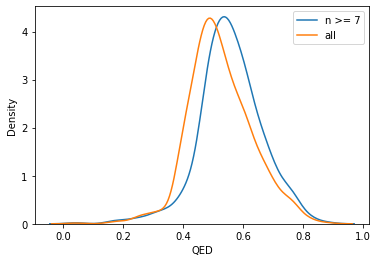

In [10]:
sns.kdeplot(data=np.delete(planar_orig_qeds, np.where(planar_ns<7)), label = 'n >= 7')
sns.kdeplot(data=np.delete(planar_orig_qeds, np.where(planar_ns<=0)), label = 'all')
plt.legend()
plt.xlabel('QED')
plt.show()

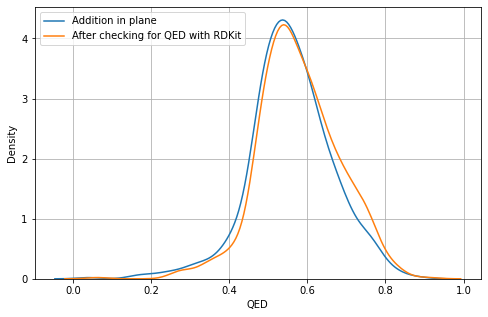

In [33]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=np.delete(planar_orig_qeds, np.where(planar_ns<7)), label = 'Addition in plane')
sns.kdeplot(data=np.delete(planar_max_qeds, np.where(planar_ns<7)), label = 'After checking for QED with RDKit')
plt.legend()
plt.xlabel('QED')
plt.grid()
plt.show()

In [12]:
planar_max_qeds = np.maximum(planar_orig_qeds, planar_plan_qeds)
print(np.sum(planar_ns>=7))
np.sum(np.delete(planar_plan_qeds-planar_orig_qeds, np.where(planar_ns<7))>0)

693


214

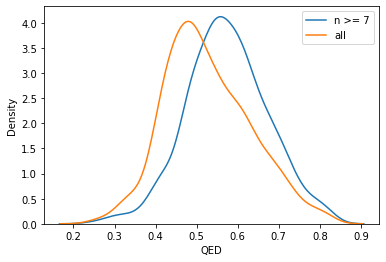

In [13]:
sns.kdeplot(data=np.delete(all_orig_qeds, np.where(all_ns<7)), label = 'n >= 7')
sns.kdeplot(data=np.delete(all_orig_qeds, np.where(all_ns<=0)), label = 'all')
plt.legend()
plt.xlabel('QED')
plt.show()

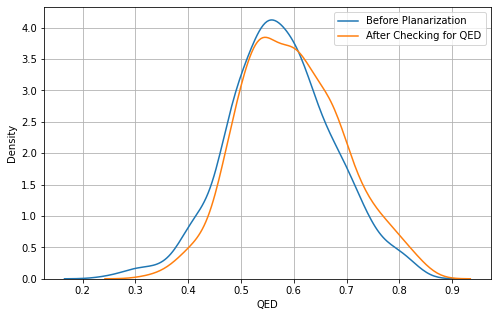

In [32]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=np.delete(all_orig_qeds, np.where(all_ns<7)), label = 'Before Planarization')
sns.kdeplot(data=np.delete(all_max_qeds, np.where(all_ns<7)), label = 'After Checking for QED')
plt.legend()
plt.xlabel('QED')
plt.grid()
plt.show()

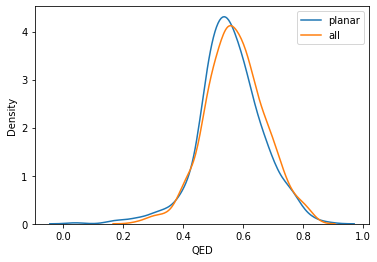

In [15]:
sns.kdeplot(data=np.delete(planar_orig_qeds, np.where(planar_ns<7)), label = 'planar')
sns.kdeplot(data=np.delete(all_orig_qeds, np.where(all_ns<7)), label = 'all')
plt.legend()
plt.xlabel('QED')
plt.show()

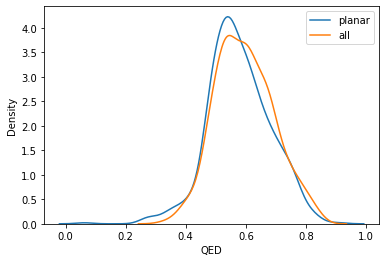

In [16]:
sns.kdeplot(data=np.delete(planar_max_qeds, np.where(planar_ns<7)), label = 'planar')
sns.kdeplot(data=np.delete(all_max_qeds, np.where(all_ns<7)), label = 'all')
plt.legend()
plt.xlabel('QED')
plt.show()

In [17]:
all_max_sascores = [
    all_orig_sascores[i] if all_max_qeds[i] == all_orig_qeds[i] else all_plan_sascores[i]
    for i in range(all_ns.shape[0])
]
all_max_logps = [
    all_orig_logps[i] if all_max_qeds[i] == all_orig_qeds[i] else all_plan_logps[i]
    for i in range(all_ns.shape[0])
]

In [18]:
planar_max_sascores = [
    planar_orig_sascores[i] if planar_max_qeds[i] == planar_orig_qeds[i] else planar_plan_sascores[i]
    for i in range(planar_ns.shape[0])
]
planar_max_logps = [
    planar_orig_logps[i] if planar_max_qeds[i] == planar_orig_qeds[i] else planar_plan_logps[i]
    for i in range(planar_ns.shape[0])
]

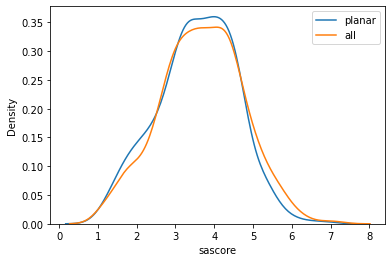

In [19]:
sns.kdeplot(data=np.delete(planar_max_sascores, np.where(planar_ns<7)), label = 'planar')
sns.kdeplot(data=np.delete(all_max_sascores, np.where(all_ns<7)), label = 'all')
# sns.kdeplot(data=data_props['sascore'], label = 'data')
plt.legend()
plt.xlabel('sascore')
plt.show()

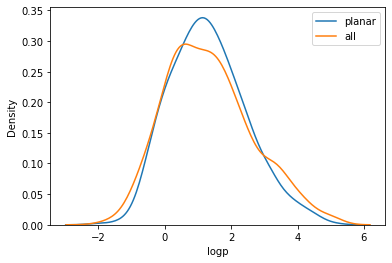

In [20]:
sns.kdeplot(data=np.delete(planar_max_logps, np.where(planar_ns<7)), label = 'planar')
sns.kdeplot(data=np.delete(all_max_logps, np.where(all_ns<7)), label = 'all')
# sns.kdeplot(data=data_props['sascore'], label = 'data')
plt.legend()
plt.xlabel('logp')
plt.show()

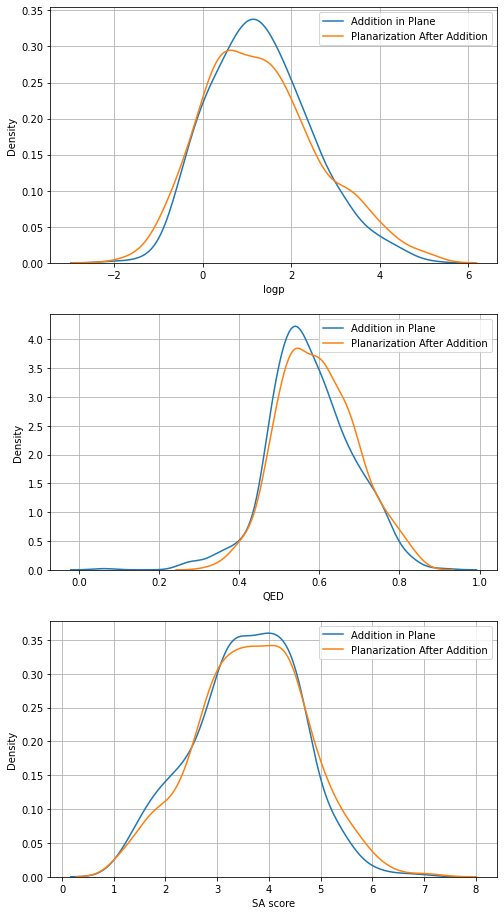

In [31]:
plt.figure(figsize=(8,16))

plt.subplot(3,1,1)
sns.kdeplot(data=np.delete(planar_max_logps, np.where(planar_ns<7)), label = 'Addition in Plane')
sns.kdeplot(data=np.delete(all_max_logps, np.where(all_ns<7)), label = 'Planarization After Addition')
# sns.kdeplot(data=data_props['sascore'], label = 'data')
plt.legend()
plt.grid()
plt.xlabel('logp')


plt.subplot(3,1,2)
sns.kdeplot(data=np.delete(planar_max_qeds, np.where(planar_ns<7)), label = 'Addition in Plane')
sns.kdeplot(data=np.delete(all_max_qeds, np.where(all_ns<7)), label = 'Planarization After Addition')
plt.legend()
plt.grid()
plt.xlabel('QED')


plt.subplot(3,1,3)
sns.kdeplot(data=np.delete(planar_max_sascores, np.where(planar_ns<7)), label = 'Addition in Plane')
sns.kdeplot(data=np.delete(all_max_sascores, np.where(all_ns<7)), label = 'Planarization After Addition')
# sns.kdeplot(data=data_props['sascore'], label = 'data')
plt.legend(loc=1)
plt.grid()
plt.xlabel('SA score')


plt.show()

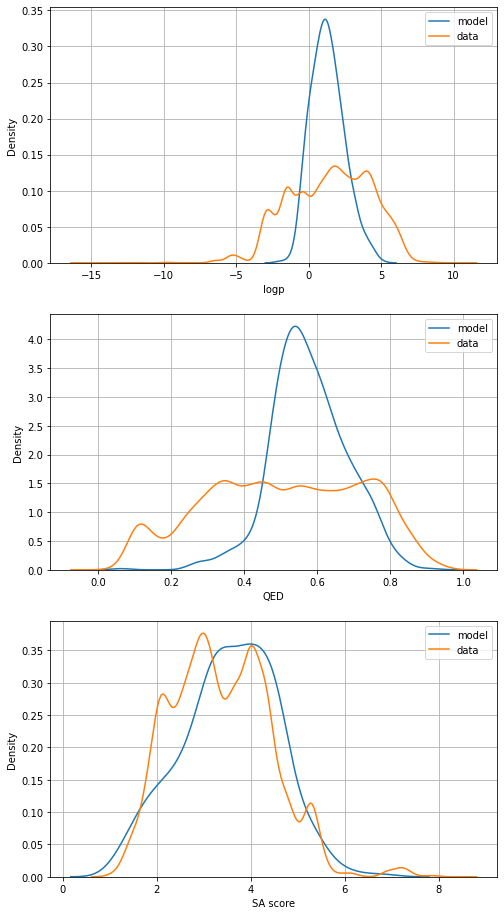

In [30]:
plt.figure(figsize=(8,16))

plt.subplot(3,1,1)
sns.kdeplot(data=np.delete(planar_max_logps, np.where(planar_ns<7)), label = 'model')
sns.kdeplot(data=data_props['logp'], label = 'data')
plt.legend()
plt.grid()
plt.xlabel('logp')


plt.subplot(3,1,2)
sns.kdeplot(data=np.delete(planar_max_qeds, np.where(planar_ns<7)), label = 'model')
sns.kdeplot(data=data_props['qed'], label = 'data')
plt.legend()
plt.grid()
plt.xlabel('QED')


plt.subplot(3,1,3)
sns.kdeplot(data=np.delete(planar_max_sascores, np.where(planar_ns<7)), label = 'model')
sns.kdeplot(data=data_props['sascore'], label = 'data')
plt.legend()
plt.grid()
plt.xlabel('SA score')


plt.show()

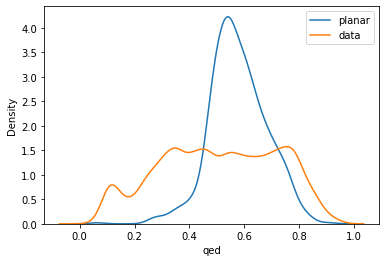

In [22]:
sns.kdeplot(data=np.delete(planar_max_qeds, np.where(planar_ns<7)), label = 'planar')
sns.kdeplot(data=data_props['qed'], label = 'data')
plt.legend()
plt.xlabel('qed')
plt.show()

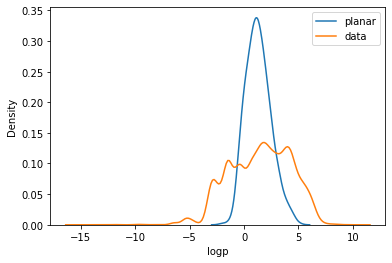

In [23]:
sns.kdeplot(data=np.delete(planar_max_logps, np.where(planar_ns<7)), label = 'planar')
sns.kdeplot(data=data_props['logp'], label = 'data')
plt.legend()
plt.xlabel('logp')
plt.show()

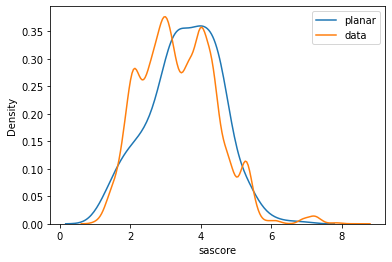

In [24]:
sns.kdeplot(data=np.delete(planar_max_sascores, np.where(planar_ns<7)), label = 'planar')
sns.kdeplot(data=data_props['sascore'], label = 'data')
plt.legend()
plt.xlabel('sascore')
plt.show()

In [5]:
lig_df = pd.read_csv('../../smiles_2.csv', header=None)
lig_smiles = list(lig_df[0])
lig_paths = list(lig_df[1])

In [6]:
rdmols = []
for smiles in lig_smiles:
    rdmols.append(Chem.MolFromSmiles(smiles))
    
fgrps = [rdkit_gen.GetFingerprint(mol) for mol in rdmols]

In [26]:
all_similarities = []
for i in tqdm(range(1000)):
    try:
        newmol = next(iter(Chem.SDMolSupplier('./outputs/planar/'+str(i)+'.sdf')))
    except:
        all_similarities.append(-1)
        # where_maxs.append(-1)
        continue
    newimg, qed, sascore, logp = generate_image(newmol, 'tmp')
    # if(qed<0.7): continue
    newsmiles = Chem.MolToSmiles(newmol)
    newmol = Chem.MolFromSmiles(newsmiles)
    newfgrp = rdkit_gen.GetFingerprint(newmol)
    similarity = DataStructs.BulkTanimotoSimilarity(newfgrp, fgrps)
    # similarities.append(np.max(similarity))
    # where_maxs.append(np.where(np.array(similarity) == np.max(similarity)))
    ix = np.argmax(similarity)
    datamol = next(iter(Chem.SDMolSupplier(data_path+lig_paths[ix][1:])))
    dataimg, qed, sascore, logp = generate_image(datamol, 'tmp')
    res = Image.new("RGB", (600, 370), (255,255,255))
    res.paste(newimg, (0,0))
    res.paste(dataimg, (300,0))
    I1 = ImageDraw.Draw(res)
    font = ImageFont.truetype("myfont.ttf", 15)
    I1.text((250, 350), ("Similarity %.2f" % (np.max(similarity))), fill=(0, 0, 0), font=font)
    res.save('./outputs/planar/'+str(i)+'_data.png')
    all_similarities.append(np.max(similarity))
all_similarities = np.array(all_similarities)

  2%|█▍                                                                              | 18/1000 [00:05<01:21, 11.98it/s][18:59:25] atom 0 has specified valence (4) smaller than the drawn valence 5.
[18:59:25] atom 1 has specified valence (1) smaller than the drawn valence 2.
  4%|███                                                                             | 38/1000 [00:06<01:00, 15.87it/s][18:59:26] atom 0 has specified valence (1) smaller than the drawn valence 2.
[18:59:26] atom 1 has specified valence (4) smaller than the drawn valence 5.
 12%|█████████▍                                                                     | 120/1000 [00:12<00:49, 17.71it/s][18:59:31] atom 0 has specified valence (4) smaller than the drawn valence 5.
[18:59:31] atom 1 has specified valence (1) smaller than the drawn valence 2.
 14%|██████████▉                                                                    | 138/1000 [00:13<00:54, 15.91it/s][18:59:33] atom 0 has specified valence (3) smaller than

In [7]:
planar_similarities = []
for i in tqdm(range(1000)):
    try:
        newmol = next(iter(Chem.SDMolSupplier('./outputs/planar_planar/'+str(i)+'.sdf')))
    except:
        planar_similarities.append(-1)
        # where_maxs.append(-1)
        continue
    newimg, qed, sascore, logp = generate_image(newmol, 'tmp')
    # if(qed<0.7): continue
    newsmiles = Chem.MolToSmiles(newmol)
    newmol = Chem.MolFromSmiles(newsmiles)
    newfgrp = rdkit_gen.GetFingerprint(newmol)
    similarity = DataStructs.BulkTanimotoSimilarity(newfgrp, fgrps)
    # similarities.append(np.max(similarity))
    # where_maxs.append(np.where(np.array(similarity) == np.max(similarity)))
    ix = np.argmax(similarity)
    datamol = next(iter(Chem.SDMolSupplier(data_path+lig_paths[ix][1:])))
    dataimg, qed, sascore, logp = generate_image(datamol, 'tmp')
    res = Image.new("RGB", (600, 370), (255,255,255))
    res.paste(newimg, (0,0))
    res.paste(dataimg, (300,0))
    I1 = ImageDraw.Draw(res)
    font = ImageFont.truetype("myfont.ttf", 15)
    I1.text((250, 350), ("Similarity %.2f" % (np.max(similarity))), fill=(0, 0, 0), font=font)
    res.save('./outputs/planar_planar/'+str(i)+'_data.png')
    planar_similarities.append(np.max(similarity))
planar_similarities = np.array(planar_similarities)

 64%|██████████████████████████████████████████████████▉                            | 645/1000 [00:45<00:20, 17.09it/s][23:13:51] atom 6 has specified valence (3) smaller than the drawn valence 4.
[23:13:51] atom 8 has specified valence (1) smaller than the drawn valence 2.
 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [00:54<00:12, 16.81it/s][23:14:00] atom 0 has specified valence (3) smaller than the drawn valence 4.
[23:14:00] atom 2 has specified valence (1) smaller than the drawn valence 2.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:07<00:00, 14.78it/s]


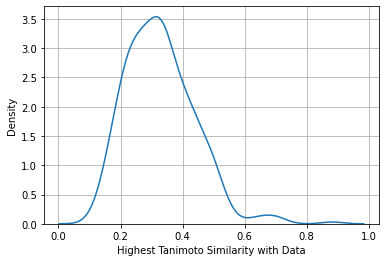

In [13]:
sns.kdeplot(data=np.delete(planar_similarities, np.where(planar_ns<10)), label = 'planar')
# sns.kdeplot(data=np.delete(all_similarities, np.where(all_ns<10)), label = 'all')
# sns.kdeplot(data=data_props['sascore'], label = 'data')
# plt.legend()
plt.grid()
plt.xlabel('Highest Tanimoto Similarity with Data')
plt.show()

In [29]:
similarities_1 = []
for i in range(1000):
    if(all_ns[i]<8): similarities_1.append(-1)
    else: similarities_1.append(all_similarities[i])
similarities_1 = np.array(similarities_1)

sorted_ix = np.argsort(-similarities_1)

for i in tqdm(range(1000)):
    if(similarities_1[sorted_ix[i]] == -1): continue
    
    shutil.copy('outputs/planar/'+str(sorted_ix[i])+'_data.png', 'outputs/planar/top_tanimoto/'+str(i)+'.png')

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 295.09it/s]


In [30]:
similarities_2 = []
for i in range(1000):
    if(planar_ns[i]<8): similarities_2.append(-1)
    else: similarities_2.append(planar_similarities[i])
similarities_2 = np.array(similarities_2)

sorted_ix = np.argsort(-similarities_2)

for i in tqdm(range(1000)):
    if(similarities_2[sorted_ix[i]] == -1): continue
    
    shutil.copy('outputs/planar_planar/'+str(sorted_ix[i])+'_data.png', 'outputs/planar_planar/top_tanimoto/'+str(i)+'.png')

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 255.23it/s]


In [58]:
def get_graph(mol):
    Chem.Kekulize(mol)
    atoms = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    am = Chem.GetAdjacencyMatrix(mol,useBO=True)
    for i,atom in enumerate(atoms):
        am[i,i] = atom
    G = nx.from_numpy_matrix(am)
    return G

def GDE_mols(mol1, mol2):
    g1 = get_graph(mol1)
    g2 = get_graph(mol2)
    for x in nx.optimize_graph_edit_distance(g1, g2, edge_match=lambda a,b: a['weight'] == b['weight']): return x

In [76]:
gde_mins = []
gde_min_ixs = []
for j in tqdm(range(1000)):
    
    if(planar_ns[j] < 8):
        gde_mins.append(1000)
        gde_min_ixs.append(-1)
        continue
    
    newmol = next(iter(Chem.SDMolSupplier('./outputs/planar_planar/'+str(j)+'.sdf')))
    newimg, qed, sascore, logp = generate_image(newmol, 'tmp')
    newsmiles = Chem.MolToSmiles(newmol)
    newmol = Chem.MolFromSmiles(newsmiles)
    # newmol
    gde_min = 1000
    gde_min_ix = -1
    for i in range(len(rdmols)):
        
        if(rdmols[i].GetNumAtoms() > newmol.GetNumAtoms()): continue
        gde = GDE_mols(newmol, rdmols[i])

        if(gde < gde_min):
            gde_min = gde
            gde_min_ix = i
    
    gde_mins.append(gde_min)
    gde_min_ixs.append(gde_min_ix)
    
    datamol = next(iter(Chem.SDMolSupplier(data_path+lig_paths[gde_min_ix][1:])))
    dataimg, qed, sascore, logp = generate_image(datamol, 'tmp')
    res = Image.new("RGB", (600, 370), (255,255,255))
    res.paste(newimg, (0,0))
    res.paste(dataimg, (300,0))
    I1 = ImageDraw.Draw(res)
    font = ImageFont.truetype("myfont.ttf", 15)
    I1.text((250, 350), ("Edit Distance %.2f" % gde_min), fill=(0, 0, 0), font=font)
    res.save('./outputs/planar_planar/'+str(j)+'_gde.png')

 65%|████████████████████████████████████████████████▍                          | 646/1000 [1:40:51<1:14:07, 12.56s/it][02:39:34] atom 6 has specified valence (3) smaller than the drawn valence 4.
[02:39:34] atom 8 has specified valence (1) smaller than the drawn valence 2.
 79%|█████████████████████████████████████████████████████████████                | 793/1000 [2:06:20<43:39, 12.65s/it][03:05:03] atom 0 has specified valence (3) smaller than the drawn valence 4.
[03:05:03] atom 2 has specified valence (1) smaller than the drawn valence 2.
100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [2:34:40<00:00,  9.28s/it]


In [65]:
gde_min_ix

22675

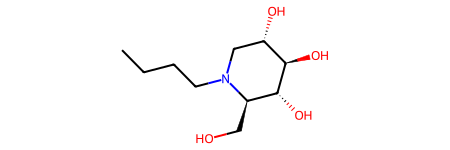

In [66]:
rdmols[22675]

In [67]:
gde_min

8.0

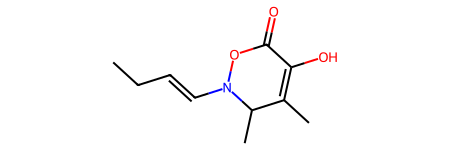

In [50]:
newmol

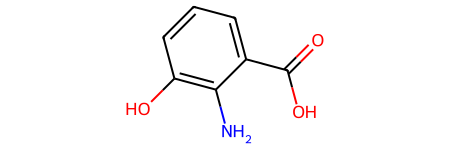

In [60]:
rdmols[0]

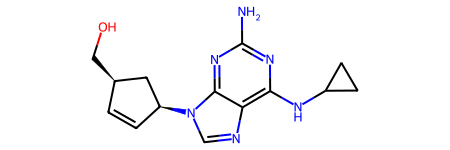

In [61]:
rdmols[1]

In [69]:
rdmols[0].GetNumAtoms()

11